# Wyznaczanie minimalnego okręgu i prostokąta zawierającego zbiór punktów - kod i dokumentacja

Weronika Ormaniec


## Konfiguracja wizualizacji

W tej sekcji zdefiniowane jest narzędzie do wizualizacji zgodnie z wersją z laboratorium 4. Została do niego dodana jedynie możliwość rysowania okręgu.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
from matplotlib.patches import Circle, PathPatch
%matplotlib notebook

import json as js
import random
import copy
import functools

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []
        self.adding_circles = False
        self.added_circles = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        for collection in (self.scenes[self.i].circles + self.added_circles):
            if len(collection.circles) > 0:
                for c in collection.circles:
                    self.ax.add_patch(plt.Circle(c[0], c[1], color=c[2], alpha=1, fill=False))
        self.ax.autoscale(autoscaling)
        self.ax.set_aspect('equal')
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
class Scene:
    def __init__(self, points=[], lines=[], circles=[]):
        self.points=points
        self.lines=lines
        self.circles=circles

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class CirclesCollection:
    def __init__(self, circles):
        self.circles = circles
        
    def add(self, circle, **kwargs):
        self.circles.append(circle)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]], 
                                [CirclesCollection(circlesCol) for circlesCol in scene["circles"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)

        return [b_prev, b_next, b_add_point]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines], 
                          "circles":[circlesCol.lines for circlesCol in scene.circles]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
        
    def get_added_circles(self):
        if self.callback:
            return self.callback.added_circles
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

## Struktury i generowanie danych


### Struktury geometryczne

Zdefiniowane struktury geometryczne i ich metody, to:
* **Wektor** implementujący odejmowanie, mnożenie przez skalar, obliczanie wektora prostopadłego, obliczanie swojej długości
* **Punkt** implementujący dodawanie, mnożenie przez skalar, porównanie, konwersję do wektora
* **Okrąg**
* **Prostokąt** implementujący porównanie ze względu na pole/obwód, aktualizowanie wierzchołków na podstawie punktów podparcia, zwracanie prostokąta w postaci odcinków, wierzchołków lub punktów podparcia

In [3]:
class Vector():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __rmul__(self, other):
        return Vector(other*self.x, other*self.y)
    
    def __sub__(self, other):
        return Vector(self.x-other.x, self.y-other.y)
    
    def __str__(self):
        return '['+str(self.x)+', '+str(self.y)+']'
    
    def __repr__(self):
        return '['+str(self.x)+', '+str(self.y)+']'
        
    def perp(self): #wektor prostopadły
        return Vector(self.y, -self.x)
    
    def norm(self): #długość
        l = np.array([self.x, self.y])
        return np.linalg.norm(l)      

class Point():
    def __init__(self, x, y):
        self.x = x
        self.y = y
 
    def __rmul__(self, other):
        return Point(other*self.x, other*self.y)
        
    def __add__(self, other):
        return Point(self.x+other.x, self.y+other.y)
        
    def __str__(self):
        return '('+str(self.x)+', '+str(self.y)+'): '
    
    def __repr__(self):
        return '('+str(self.x)+', '+str(self.y)+'): \n'
    
    def __lt__(self, other):
        return self.y > other.y
    
    def to_vector(self):
        return Vector(self.x, self.y)
            
class Circle():
    def __init__(self, s, r):
        self.s = s
        self.r = r
        
    def __str__(self):
        return '{s='+str(self.s)+', r='+str(self.r)+'}'
    
class Rectangle():
    def __init__(self, U, index, vertices, ver='area'):
        self.U = U #wektory, wzdłuż których leżą boki prostokąta
        self.index = index #indeksy punktów wspomagających boki prostokąta
        self.area = 0
        self.perim = 0
        self.vertices = vertices #punkty wewnątrz prostokąta
        self.ver = ver #co minimalizuje
        self.a = None
        self.b = None
        self.c = None
        self.d = None
        
    def __lt__(self, other):
        if self.ver=='area':
            return self.area < other.area
        else:
            return self.perim < other.perim
        
    def update_vertices(self):
        self.a = intersection(self.vertices[self.index[3]], self.U[1], self.vertices[self.index[0]], self.U[0])
        self.b = intersection(self.vertices[self.index[1]], self.U[1], self.vertices[self.index[0]], self.U[0])
        self.c = intersection(self.vertices[self.index[1]], self.U[1], self.vertices[self.index[2]], self.U[0])
        self.d = intersection(self.vertices[self.index[3]], self.U[1], self.vertices[self.index[2]], self.U[0])
        
        nodes = [self.a.to_vector(), self.b.to_vector(), self.c.to_vector(), self.d.to_vector()]
        self.area = (nodes[0]-nodes[1]).norm()*(nodes[1]-nodes[2]).norm()
        self.perim = 2*((nodes[0]-nodes[1]).norm()+(nodes[1]-nodes[2]).norm())
            
    def get_segments(self):
        return [[(self.a.x, self.a.y), (self.b.x, self.b.y)], [(self.b.x, self.b.y), (self.c.x, self.c.y)],
               [(self.c.x, self.c.y), (self.d.x, self.d.y)], [(self.d.x, self.d.y), (self.a.x, self.a.y)]]
        
    def get_rectangle(self):
        return [self.a, self.b, self.c, self.d]
    
    def get_supporting(self):
        return [self.vertices[ind] for ind in self.index]

### Funkcje obsługujące narzędzie graficzne

In [4]:
def file_to_data(filename):
    points = []
    with open(filename) as json_file:
        data = json.load(json_file)
        #print(data[0]['lines'][0])
        for s in data[0]['points'][0]:
            if s:
                p1 = Point(s[0], s[1])
                points.append(p1)            
    return points

def data_to_file(plot, filename):
    with open(filename, 'w') as file:
        file.write(plot.toJson())
        
def transform_points(p):
    return (p.x, p.y)

### Funkcje generujące zbiory punktów
* **random_points()** - generuje $n$ punktów o współrzędnych z przedziału $(a, b)$.
* **random_points_on_circle()** - generuje $n$ punktów na okręgu o promieniu $r$ i środku w punkcie $(0, 0)$.
* **random_points_on_line()** - generuje $n$ punktów, takich że $x \in (a, b)$, $y=w\cdot x+v$.
* **random_points_on_regular_convex(n)** - generuje wierzchołki $n$-kąta foremnego wpisanego w okąg o promieniu $r$ i środku w punkcie $(0, 0)$.

In [5]:
def random_points(n=100, a=-100, b=100):
    return [Point(random.uniform(a, b), random.uniform(a, b)) for i in range(n)]

def random_points_on_circle(n=100, s=(0,0), r=10):
    rand = 4*np.random.random(n)
    return [Point(r*np.cos((np.pi/2)*i)+s[0], r*np.sin((np.pi/2)*i)+s[1]) for i in rand]

def random_points_on_line(n=100, a=-100, b=100, w=1, v=1):
    return [Point(x, w*x+v) for x in [random.uniform(a, b) for i in range(n)]]

def random_points_on_regular_convex(n, s=(0, 0), r=10):
    return [Point(r*np.cos(2*np.pi*i/n)+s[0], r*np.sin(2*np.pi*i/n)+s[1]) for i in range(n)]

## Minimalny okrąg zawierające zbiór punktów

### Funkcje pomocnicze
* **distance(p1, p2)** - oblicza odległość między punktami $p_1$ i $p_2$.
* **middle_point(p1, p2)** - oblicza opunkt w środku odcinka tworzonego przez punkty $p_1$ i $p_2$.
* **in_circle(c, p)** - zwraca wartość $True$ jeśli punkt $p$ leży wewnątrz okręgu $c$ i $False$ w przeciwnym przypadku.
* **min_circle_2(p1, p2)** - zwraca okrąg, którego średnicą jest odcinek utworzony przez punkty $p_1$, $p_2$.
* **min_circle_3(a, b, c)** - zwraca okrąg na trójkącie o wierzchołkach w punktach $a$, $b$, $c$.

Środek okręgu opisanego na trójkącie obliczany jest według wyprowadzonego wzoru:
$$x_s = \frac{(x_c^2-x_a^2)(y_b-y_a)-(x_b^2-x_a^2)(y_c-y_a) + (y_a-y_c)(y_c-y_b)(y_b-y_a)}{2(x_c-x_a)(y_b-y_a)-2(x_b-x_a)(y_c-y_a)}$$
$$y_s = \frac{x_a-x_b}{y_b-y_a}(x_s-\frac{1}{2}(x_a+x_b))+\frac{1}{2}(y_a+y_b)$$

Jeśli punkty $a$ i $b$ mają tę samą współrzędną $y$, to zastępuję punkt $a$ punktem $c$.



In [7]:
def distance(p1, p2):
    return np.sqrt(np.power(p1.x-p2.x, 2)+np.power(p1.y-p2.y, 2))

def middle_point(p1, p2):
    return 0.5*(p1+p2)

def in_circle(c, p, eps=10**(-6)):
    return distance(c.s, p) <= c.r + eps

def min_circle_2(p1, p2):
    r = 0.5*distance(p1, p2)
    s = middle_point(p1, p2)
    return Circle(s, r)

def min_circle_3(a, b, c, eps=10**(-6)):
    x_s = ((np.power(c.x, 2)-np.power(a.x, 2))*(b.y-a.y)-
            (np.power(b.x, 2)-np.power(a.x, 2))*(c.y-a.y)+
            (c.y-b.y)*(c.y-a.y)*(b.y-a.y))/(2.0*(c.x-a.x)*(b.y-a.y)-2.0*(b.x-a.x)*(c.y-a.y))
    if abs(b.y-a.y)<eps:
        y_s = (a.x-b.x)/(b.y-a.y)*(x_s-0.5*(a.x+b.x))+0.5*(a.y+b.y)
    else:
        y_s = (c.x-b.x)/(b.y-c.y)*(x_s-0.5*(c.x+b.x))+0.5*(c.y+b.y)
    
    s = Point(x_s, y_s)
    r = distance(s, a)
    return Circle(s, r)

### Główny algorytm

* **min_disc_with_2_points(P, q1, q2, sc, state)** - wyznacza minimalny okrąg przechodzący przez punkty $q_1$, $q_2$, zawierający wszystkie punkty ze zbioru $P$ oraz aktualizuje wizualizację algorytmu o kolejny krok.
* **min_disc_with_point(P, q, sc, state)** - wyznacza minimalny okrąg przechodzący przez punkty $q$, zawierający wszystkie punkty ze zbioru $P$ oraz aktualizuje wizualizację algorytmu o kolejny krok.
* **min_disc(P)** - wyznacza minimalny okrąg zawierający zbiór punktów $P$ oraz generuje wizualizację poszczególnych kroków algorytmu.

Algorytm wyznaczania minimalnego okręgu zawierającego zbiór punktów działa w amortyzowanym czasie $O(n)$. Szczegółowy opis działania algorytmu oraz krótkie uzasadnienie złożoności obliczeniowej znajduje się w dołączonej prezentacji.

In [8]:
def min_disc_with_2_points(P, q1, q2, sc, state):
    D = min_circle_2(q1, q2)
    
    ##wizualizacja
    state1 = copy.deepcopy(state)
    state1.points.append(PointsCollection([transform_points(x) for x in [q1, q2]], color='green'))
    state1.circles.append(CirclesCollection([[(D.s.x, D.s.y), D.r, 'green']]))
    sc.append(state1)
    ##
    
    for i in range(len(P)):
        if not in_circle(D, P[i]):
            D = min_circle_3(P[i], q1, q2) 
            
        ##wizualizacja
        state1 = copy.deepcopy(state)
        state1.points.append(PointsCollection([transform_points(x) for x in P[:i+1]+[q1, q2]], color='green'))
        state1.circles.append(CirclesCollection([[(D.s.x, D.s.y), D.r, 'green']]))
        sc.append(state1)
        ##
        
    return D

def min_disc_with_point(P, q, sc, state):
    D = min_circle_2(q, P[0])
    
    ##wizualizacja
    state1 = copy.deepcopy(state)
    state1.points.append(PointsCollection([transform_points(x) for x in [q, P[0]]], color='magenta'))
    state1.circles.append(CirclesCollection([[(D.s.x, D.s.y), D.r, 'magenta']]))
    sc.append(state1)
    ##
    
    for i in range(1, len(P)):
        if not in_circle(D, P[i]):
            D = min_disc_with_2_points(P[:i], P[i], q, sc, state1)
        ##wizualizacja
        state1 = copy.deepcopy(state)
        state1.points.append(PointsCollection([transform_points(x) for x in P[:i+1]+[q]], color='magenta'))
        state1.circles.append(CirclesCollection([[(D.s.x, D.s.y), D.r, 'magenta']]))
        sc.append(state1)
        ##
    return D

def min_disc(P):
    ##wizualizacja
    sc = [Scene([PointsCollection([transform_points(x) for x in P])])]
    ##
    
    if len(P)<2:
        return Circle(0, 0), sc

    
    random.shuffle(P)
    D = min_circle_2(P[0], P[1])
    
    for i in range(2, len(P)):
        
        ##wizualizacja
        state = Scene([PointsCollection([transform_points(x) for x in P], color='red'), 
                       PointsCollection([transform_points(x) for x in P[i:]])], 
                        [LinesCollection([])],
                        [CirclesCollection([[(D.s.x, D.s.y), D.r, 'red']])])
        sc.append(state)
        ##
        
        if not in_circle(D, P[i]):
            D = min_disc_with_point(P[:i], P[i], sc, state)
            
    ##wizualizacja       
    sc.append(Scene([PointsCollection([transform_points(x) for x in P], color='red')], 
                        [LinesCollection([])],
                        [CirclesCollection([[(D.s.x, D.s.y), D.r, 'red']])]))
    ##
    
    return (D, sc)

### Przykład działania

In [9]:
#generowanie punktów wybraną funkcją
points = random_points(n=10)

<IPython.core.display.Javascript object>


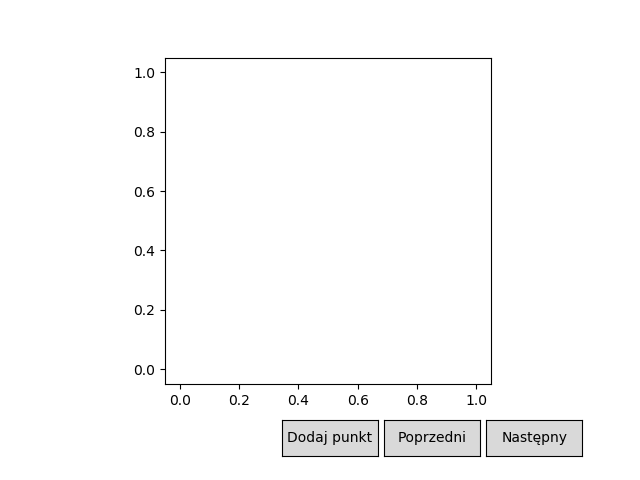

In [11]:
#rysowanie - po zaznaczeniu punktów, należy jeszcze wywołać kod z kolejnej komórki
%matplotlib notebook
plot = Plot()
plot.draw()

In [ ]:
plot2 = Plot([plot.get_added_elements()])
data_to_file(plot2, 'points2.json')
points = file_to_data('points2.json')

<IPython.core.display.Javascript object>


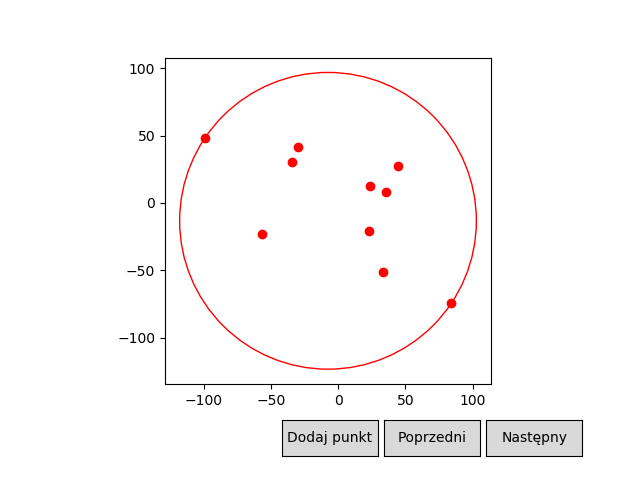

In [12]:
#wizualizacja działania algorytmu
%matplotlib notebook
D, sc = min_disc(points)
plot = Plot(sc)
plot.draw()

## Prostokąt o najmniejszym polu powierzchni/obwodzie zawierający zbiór punktów

### Otoczka wypukła
* **det(b, c, a)** - oblicza wyznacznik potrzebny do sortowania kątowego używanego w algorytmie Grahama. Nietypowa kolejność argumentów wynika z konieczności przekazania tej funkcji do funkcji częściowo ewaluującej functools.partial(). Wyznacznik niestandardowo zwraca wartość ujemną, gdy punkty $a$, $b$, $c$ są skierowane przeciwnie do wskazówek zegara.
* **find_starting_point(points)** - przyjmuje zbiór punktów i wyznacza początkowy punkt otoczki dla algorytmu Grahama, czyli punkt o najmniejszej współrzędnej $y$. Jeśli istnieje więcej elementów o najmniejszej współrzędnej $y$, wybiera ten z najmniejszą wartością współrzędnej $x$.
* **lenght(a, b)** - wyznacza długość odcinka utworzonego przez puntty $a$, $b$.
* **eliminate_duplicates(points, p0)** - przyjmuje listę punktów posortowanych kątowo względem prostej równoległej do osi $0X$, przechodzącej przez punkt $p_0$. Zwraca tak samo uporządkowaną listę bez duplikatów w ustalonym porządku.
* **Graham(P)** - wyznacza otoczkę wypukłą zbioru $P$ jeśli $|P|>2$ i punkty z $P$ nie należą do jednej prostej.

In [14]:
def det(b, c, a):
    return (b.y-a.y)*(c.x-b.x)-(c.y-b.y)*(b.x-a.x)

def find_starting_point(points):
    start = points[0]
    i = 0
    ind = 0
    for point in points:
        if point.y<start.y:
            start = point
            ind = i
        elif point.y==start.y:
            if point.x<start.x:
                start = point
                ind = i
        i+=1
                
    return (start, ind)

def length(a, b):
    l = np.array([a.x-b.x, a.y-b.y])
    return np.linalg.norm(l)

def eliminate_duplicates(points, p0, eps):
    no_duplicates = []
    curr = points[0]
    for i in range(len(points)):
        ang = det(curr, points[i], p0) 
        if abs(ang) < eps and length(p0, curr)<length(p0, points[i]):
            curr = points[i]
        elif abs(ang)>eps:           
            no_duplicates.append(curr)
            curr = points[i]
        
    no_duplicates.append(curr)
            
    return no_duplicates

def graham(points, eps = 10**-10):
    if len(points)<3:
        return points
    p0, ind = find_starting_point(points)
    points = points[:ind]+points[ind+1:]

    points = sorted(points, key=functools.cmp_to_key(functools.partial(det, a=p0)))

    points = eliminate_duplicates(points, p0, eps)

    
    stack = []
    stack.append(p0)
    stack.append(points[0])
    stack.append(points[1])
    
    i = 2
    while i< len(points):
        left_side = det(stack[-2], stack[-1], points[i])
        if left_side<-eps:
            stack.append(points[i])
            i+=1
        else:
            stack.pop()
            
    return stack    

### Początkowy prostokąt
* **intersection(p1, v1, p2, v2)** - przyjmuje dwie proste jako pary $(p_i, v_i)$, gdzie $p_i$ jest punktem leżącym na prostej, a $v_i$ wektorem kierunkowym prostej i zwraca punkt przecięcia tych prostych.
* **dot(v1, v2)** - przyjmuje dwa wektory i zwraca ich iloczyn skalarny.
* **find_smallest_rectangle(vertices, ver)** - przyjmuje listę punktów, będących kolejnymi wierzchołkami wielokąta wypukłego i napis o możliwych wartościach $'area'$, $'perim'$ w zależności od tego, czy algorytm ma minializować pole powierzchni prostokąta, czy jego obwód. Zwraca minimalny prostokąt oparty jednym z boków na odcinku wyznaczanym przez pierwsze dwa punkty podanej listy.

Szczegółowy opis działania funkcji **find_smallest_rectangle(vertices, ver)** znajduje się w załączonej prezentacji.

In [15]:
def intersection(p1, v1, p2, v2):
    m = (v1.x*(p2.y-p1.y)+v1.y*(p1.x-p2.x))/(v2.x*v1.y-v2.y*v1.x)
    return Point(p2.x+m*v2.x, p2.y+m*v2.y)
      
def dot(v1, v2):
    return v1.x*v2.x+v1.y*v2.y

def find_smallest_rectangle(vertices, ver, j0 = 0, j1 = 1):    
    ux = vertices[j1].to_vector()-vertices[j0].to_vector()
    uy = -1.0*ux.perp()
    U = [ux, uy]
    
    index = [j1, j1, j1, j1]
    r = Rectangle(U, index, vertices, ver=ver)
    
    origin = vertices[j1].to_vector()
    zero = Vector(0, 0)
    support = [zero, zero, zero, zero]
    
    for i in range(len(vertices)):
        #obrót punktu
        diff = vertices[i].to_vector()-origin
        v = Vector(dot(r.U[0], diff), dot(r.U[1], diff))
        
        if v.x>support[1].x or v.x==support[1].x and v.y>support[1].y:
            r.index[1] = i
            support[1] = v
            
        if v.y>support[2].y or v.y==support[2].y and v.x<support[2].x:
            r.index[2] = i
            support[2] = v
            
        if v.x<support[3].x or v.x==support[3].x and v.y<support[3].y:
            r.index[3] = i
            support[3] = v
            
    r.update_vertices()

    return r

### Główny algorytm - "rotating calipers"
* **update_rec_vis(sc, points, r)** - przyjmuje aktualną wizualizację, zbiór punktów i nowy prostokąt $r$ i dodaje do wizualizacji obraz $r$.
* **minimum(arr)** - przyjmuje listę i zwraca indeks i wartość najpóźniej występującego minimum.
* **is_on_line(points)** - przyjmuje zbiór punktów, zwraca wartość $True$, gdy wszystkie znajdują się na jednej prostej i wartość $False$ w przeciwnym przypadku
* **triangular_convex_hull(vertices, ver, points, sc)** - przyjmuje trójelementową otoczkę wypukłą, napis o możliwych wartościach $'area'$, $'perim'$ w zależności od tego, czy algorytm ma minializować pole powierzchni prstokąta, czy jego obwód, zbiór punktów leżących wewnątrz trójelementowej otoczki i wizualizację do optymalizacji. Zwraca najmniejszy prostokąt zawierający podane punkty wraz z wizualizacją działania algorytmu. 
* **rotating_calipers(points, ver)** - przyjmuje zbiór punktów oraz napis o możliwych wartościach $'area'$, $'perim'$ w zależności od tego, czy algorytm ma minializować pole powierzchni prstokąta, czy jego obwód. Zwraca najmniejszy prostokąt zawierający podane punkty wraz z wizualizacją działania algorytmu. Nie wyznacza minimalnego prostokąta dla pojedyńczego punktu i punktów leżących na jednej prostej

Algorytm wyznaczania prostokąta o minimalnym polu powierzchni/obwodzie zawierającego zbiór punktów działa w czasie $O(n logn)$. Szczegółowy opis działania algorytmu oraz krótkie uzasadnienie złożoności obliczeniowej znajduje się w dołączonej prezentacji.

In [23]:
def update_rec_vis(sc, points, r, color='green'):
    sc.append(Scene([PointsCollection([transform_points(x) for x in points]),
                     PointsCollection([transform_points(x) for x in r.get_supporting()])],
                   [LinesCollection(r.get_segments(), color=color)]))
    
def minimum(arr):
    mini = arr[0]
    mini_ind = 0
    for ind, m in enumerate(arr):
        if m<=mini:
            mini = m
            mini_ind = ind
    return mini, mini_ind

def is_on_line(points, eps=10**(-6)):
    if len(points)<=2:
        return True
    for p in points[2:]:
        if abs(det(points[0], points[1], p))<eps:
            return True
    return False
    
def triangular_convex_hull(vertices, ver, points, sc):
    r_min = find_smallest_rectangle(vertices, ver)
    update_rec_vis(sc, points, r_min)
        
    r = find_smallest_rectangle(vertices, ver, 1, 2)
    ## wizualizacja
    update_rec_vis(sc, points, r)
    ##
    if r < r_min:
        r_min = copy.deepcopy(r)
        
    r = find_smallest_rectangle(vertices, ver, 2, 0)
    ## wizualizacja
    update_rec_vis(sc, points, r)
    ##
    if r < r_min:
        r_min = copy.deepcopy(r)
        
    return r_min


def rotating_calipers(points, ver):
    sc = [Scene([PointsCollection([transform_points(x) for x in points])])]
    if len(points)==1 or is_on_line(points):
        return Rectangle([], [], []), sc
        
    vertices = Graham(points)
    n = len(vertices)
        
    if n==3:
        min_r = triangular_convex_hull(vertices, ver, points, sc)
    else:
        r = find_smallest_rectangle(vertices, ver)
        min_r = copy.deepcopy(r)
    
        ## wizualizacja
        update_rec_vis(sc, points, r)
        ##

        for seg in range(n-1):
            angles = []
            angles_help = []
            

            for m, i in enumerate(r.index):
                h = 0
                if r.index[(m+1)%4]==i:
                    h=1
                E = Vector(r.vertices[(i+1)%n].x, r.vertices[(i+1)%n].y)-Vector(r.vertices[i].x, r.vertices[i].y)

                angles.append(((dot(((-1)**(m+h))*r.U[(m+h)%2], E.perp()))/(E.norm()))**2)

            mini, mini_ind = minimum(angles)
            
            r.index = [(r.index[mini_ind]+1)%n, r.index[(1+mini_ind)%4], 
                       r.index[(2+mini_ind)%4],r.index[(3+mini_ind)%4]]
            
            new_u_x = Vector(r.vertices[r.index[0]].x - r.vertices[(r.index[0]-1)%n].x,
                             r.vertices[r.index[0]].y - r.vertices[(r.index[0]-1)%n].y)
            new_u_y = -1.0*new_u_x.perp()
            r.U = [new_u_x, new_u_y]
            r.update_vertices()
                        
            ## wizualizacja
            update_rec_vis(sc, points, r)          
            ##
            
            if r < min_r:
                min_r = copy.deepcopy(r)
         
        
    ## wizualizacja    
    update_rec_vis(sc, points, min_r, color='red') 
    ##
    
    return min_r, sc

### Przykład działania

In [24]:
#generowanie punktów wybraną funkcją
points = random_points(n=4)

<IPython.core.display.Javascript object>


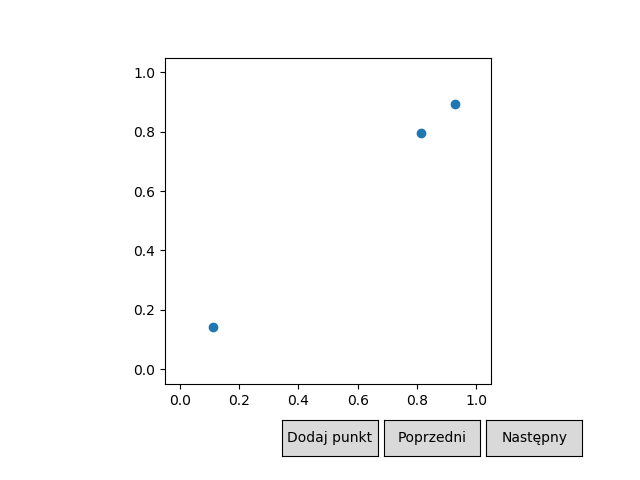

In [27]:
#rysowanie - po zaznaczeniu punktów, należy jeszcze wywołać kod z kolejnej komórki
%matplotlib notebook
plot = Plot()
plot.draw()

In [28]:
plot2 = Plot([plot.get_added_elements()])
data_to_file(plot2, 'points2.json')
points = file_to_data('points2.json')

Pole prostokąta: 0.006405664287774057
Obwód prostokąta: 2.2296089530915943


<IPython.core.display.Javascript object>


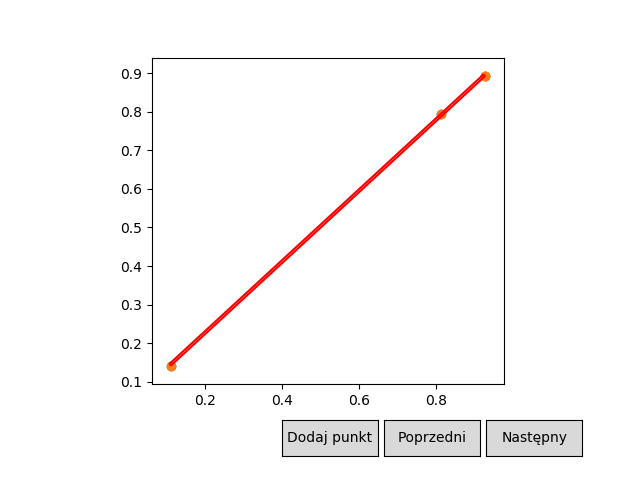

In [29]:
#wizualizacja działania algorytmu
%matplotlib notebook
r, sc = rotating_calipers(points, 'area')
print(f"Pole prostokąta: {r.area}")
print(f"Obwód prostokąta: {r.perim}")
plot = Plot(sc)
plot.draw()